In [1]:
%%bash
source activate python2
pip install --user FlowCytometryTools

discarding /opt/conda/bin from PATH
prepending /opt/conda/envs/python2/bin to PATH
You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from FlowCytometryTools import FCMeasurement
import pandas as pd
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
def getFiles(folderDir, removeExtras = 0):
    baseDir = '/home/jupyter/sd2e-community/ingest/Q0/sd2.transcriptic.upload/YeastGates/'
    fileList = sorted(os.listdir(baseDir+folderDir))
    fileList = [x for x in fileList if x[-3:] == 'fcs']
    fileList = [x for x in fileList if 'Group' not in x]
    if removeExtras:
        fileList = [x for x in fileList if len(x) < 8]
    filePaths = [baseDir+folderDir+f for f in fileList]
    return fileList, filePaths

In [3]:
def fcs2df(dfSource):
    #Rename columns specific to Transcriptic FCS files
    colNm = ['Time','FSC-A','SSC-A','FL1-A','FSC-H','SSC-H','FL1-H','FSC-W','SSC-W','FL1-W']
    cols = colNm[:]
    newCols = ['Lab','Strain','bioReplicate','techReplicate']
    cols[:0] = newCols
#    [cols.append(item) for item in newCols]

    dfNew = pd.DataFrame(columns=cols)
    
    counts = []
    for i, fileNm in enumerate(dfSource['filePath']):
        #print fileNm[-10:]
        data = dfSource.loc[i]
        sample = FCMeasurement(ID=fileNm,datafile=fileNm)
        dfT = pd.DataFrame(data=sample.data)
        dfT.columns = colNm
        dfT['Lab'] = data['lab']
        dfT['bioReplicate'] = data['bioReplicate']
        dfT['techReplicate'] = data['techReplicate']
        dfT['Strain'] = data['strainID']
        dfNew = pd.concat([dfNew,dfT])
        counts.append(len(dfT))

    dfSource['numCounts'] = counts
    dfNew = dfNew[cols]

    return dfSource, dfNew

In [4]:
def flowViz(df,lab,date):

    n = 1
    channel = 'FL{}'.format(n)
    sns.set_style('ticks')
    fig, ax = plt.subplots(4,2,figsize=(8,11),sharex=True,sharey=True)
    maxReps = int(np.max(sorted(set(df.bioReplicate))))
    sns.set_palette('cubehelix',maxReps)
    cond = ['XOR_00','XOR_01','XOR_10','XOR_11']
    for c, axR in zip(cond,range(4)):
        ax[axR,0].annotate(c,(0.05,0.85),xycoords='axes fraction')
        dfT = df[df['Strain'] == c]
        for samp in sorted(set(dfT.bioReplicate)):
            data = dfT[dfT['bioReplicate'] == samp]['{}-H'.format(channel)]
            sns.distplot(np.log10(data[data > 0]),hist=False,ax = ax[axR,0])
            ax[axR,0].set_xlim([1,6])
            data = dfT[dfT['bioReplicate'] == samp]['{}-A'.format(channel)]
            sns.distplot(np.log10(data[data > 0]),hist=False,ax = ax[axR,1])
            ax[axR,1].set_xlim([1,6])
    sns.despine()
    fig.savefig(outputDir+'plots/{}_flow_{}_{}.pdf'.format(lab,channel,date))

## Transcriptic Run01 dataframe

In [5]:
originatorLab = 'Transcriptic'
colNames = ['date','lab','well','strainID','bioReplicate',
            'techReplicate','filePath']

In [8]:
flowDate = '2017_run1_Dilute'

folderDir = 'Run 01/03 Static Flow (r1argbedjhwq3) /Diluted/'
fileList, filePaths = getFiles(folderDir, removeExtras = 0)
reps = 6
missingBeads = 4

date = [flowDate for i in range(26)]
lab = [originatorLab for i in range (26)]
well = ['{}{:02d}'.format(r,c) for r in 'EFGH' for c in range(1,6+1)]
well.insert(6,'E07')
well.insert(13,'F07')
strainList = ['XOR_00','XOR_01','XOR_10','XOR_11']
strainID = [strain for strain in strainList for rep in range(reps)]
[strainID.insert(i,'Beads') for i in [6,13]]
bioRep = [r+1 for i in range(4) for r in range(reps) ]
[bioRep.insert(i,1) for i in [6,13]]
techRep = [1 for i in range(5*reps-missingBeads)]
frame = [date, lab, well, strainID, bioRep, techRep, filePaths]
dfR1d = pd.DataFrame(frame).transpose()
dfR1d.columns = colNames

## Convert fcs files to dataframe

In [71]:
outputDir = '/home/jupyter/sd2e-community/shared-q0-hackathon/yeast-gates/flowDataFrames/Transcriptic/'

dfR2d, dfR2dilute = fcs2df(dfR2d)
dfR2d.to_csv(outputDir+'{}_{}_sampleTable.csv'.format(originatorLab,flowDate))
dfR2dilute.to_csv(outputDir+'{}_{}_flowDataFrame.csv'.format(originatorLab,flowDate))

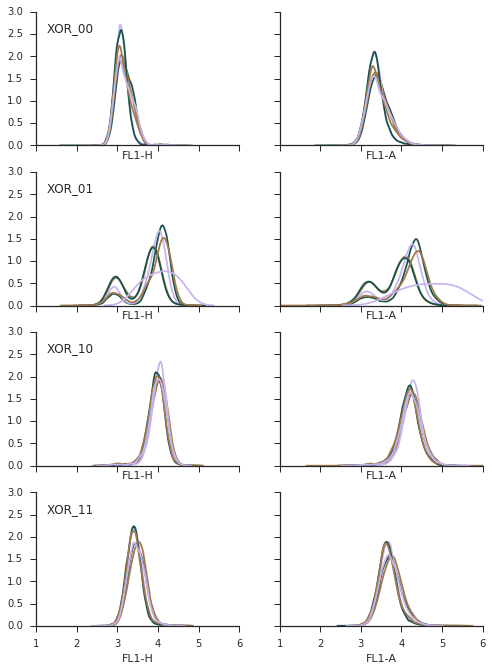

In [82]:
flowViz(dfR1dilute,originatorLab,flowDate)

## Transcriptic Run02 dataframe (100-fold dilution)

In [86]:
flowDate = '2017_run2_Dilute100'

folderDir = 'Run 02/03 Flow Normal and Diluted/1to100_01/'
fileList, filePaths = getFiles(folderDir, removeExtras = 0)
reps = 2

date = [flowDate for i in range(10)]
lab = [originatorLab for i in range (10)]
well = ['{}{:02d}'.format(r,c) for r in 'ABCD' for c in range(1,2+1)]
well.insert(2,'A04')
well.insert(5,'B04')
strainList = ['XOR_00','XOR_01','XOR_10','XOR_11']
strainID = [strain for strain in strainList for rep in range(reps)]
[strainID.insert(i,'Beads') for i in [2,5]]
bioRep = [r+1 for i in range(4) for r in range(reps) ]
[bioRep.insert(i,1) for i in [2,5]]
techRep = [1 for i in range(10)]
frame = [date, lab, well, strainID, bioRep, techRep, filePaths]
dfR2d = pd.DataFrame(frame).transpose()
dfR2d.columns = colNames

## Convert fcs files to dataframe

In [71]:
outputDir = '/home/jupyter/sd2e-community/shared-q0-hackathon/yeast-gates/flowDataFrames/Transcriptic/'

dfR2d100, dfR2dilute100 = fcs2df(dfR2d)
dfR2d100.to_csv(outputDir+'{}_{}_sampleTable.csv'.format(originatorLab,flowDate))
dfR2dilute100.to_csv(outputDir+'{}_{}_flowDataFrame.csv'.format(originatorLab,flowDate))

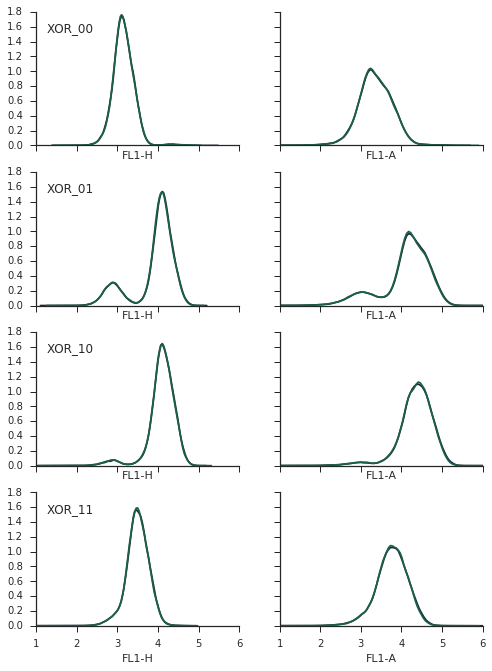

In [83]:
flowViz(dfR2dilute,originatorLab,flowDate)

## Transcriptic Run02 dataframe (10 fold dilution, run 1)

In [6]:
flowDate = '2017_run2_Dilute10_1'

folderDir = 'Run 02/03 Flow Normal and Diluted/1to10_01/'
fileList, filePaths = getFiles(folderDir, removeExtras = 0)
reps = 2

date = [flowDate for i in range(10)]
lab = [originatorLab for i in range (10)]
well = ['{}{:02d}'.format(r,c) for r in 'ABCD' for c in range(1,2+1)]
well.insert(2,'A04')
well.insert(5,'B04')
strainList = ['XOR_00','XOR_01','XOR_10','XOR_11']
strainID = [strain for strain in strainList for rep in range(reps)]
[strainID.insert(i,'Beads') for i in [2,5]]
bioRep = [r+1 for i in range(4) for r in range(reps) ]
[bioRep.insert(i,1) for i in [2,5]]
techRep = [1 for i in range(10)]
frame = [date, lab, well, strainID, bioRep, techRep, filePaths]
dfR2d = pd.DataFrame(frame).transpose()
dfR2d.columns = colNames

## Convert fcs files to dataframe

In [7]:
outputDir = '/home/jupyter/sd2e-community/shared-q0-hackathon/yeast-gates/flowDataFrames/Transcriptic/'

dfR2d10, dfR2dilute10 = fcs2df(dfR2d)
dfR2d10.to_csv(outputDir+'{}_{}_sampleTable.csv'.format(originatorLab,flowDate))
dfR2dilute10.to_csv(outputDir+'{}_{}_flowDataFrame.csv'.format(originatorLab,flowDate))

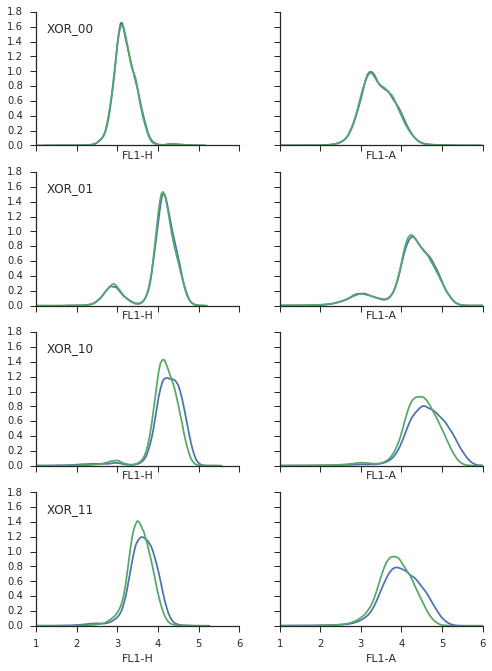

In [8]:
flowViz(dfR2dilute10,originatorLab,flowDate)

## Transcriptic Run02 dataframe (10 fold dilution, run 2)

In [9]:
flowDate = '2017_run2_Dilute10_2'

folderDir = 'Run 02/03 Flow Normal and Diluted/1to10_02/'
fileList, filePaths = getFiles(folderDir, removeExtras = 0)
reps = 2

date = [flowDate for i in range(10)]
lab = [originatorLab for i in range (10)]
well = ['{}{:02d}'.format(r,c) for r in 'ABCD' for c in range(1,2+1)]
well.insert(2,'A04')
well.insert(5,'B04')
strainList = ['XOR_00','XOR_01','XOR_10','XOR_11']
strainID = [strain for strain in strainList for rep in range(reps)]
[strainID.insert(i,'Beads') for i in [2,5]]
bioRep = [r+1 for i in range(4) for r in range(reps) ]
[bioRep.insert(i,1) for i in [2,5]]
techRep = [1 for i in range(10)]
frame = [date, lab, well, strainID, bioRep, techRep, filePaths]
dfR2d = pd.DataFrame(frame).transpose()
dfR2d.columns = colNames

## Convert fcs files to dataframe

In [12]:
outputDir = '/home/jupyter/sd2e-community/shared-q0-hackathon/yeast-gates/flowDataFrames/Transcriptic/'

dfR2d10_2, dfR2dilute10_2 = fcs2df(dfR2d)
dfR2d10_2.to_csv(outputDir+'{}_{}_sampleTable.csv'.format(originatorLab,flowDate))
dfR2dilute10_2.to_csv(outputDir+'{}_{}_flowDataFrame.csv'.format(originatorLab,flowDate))

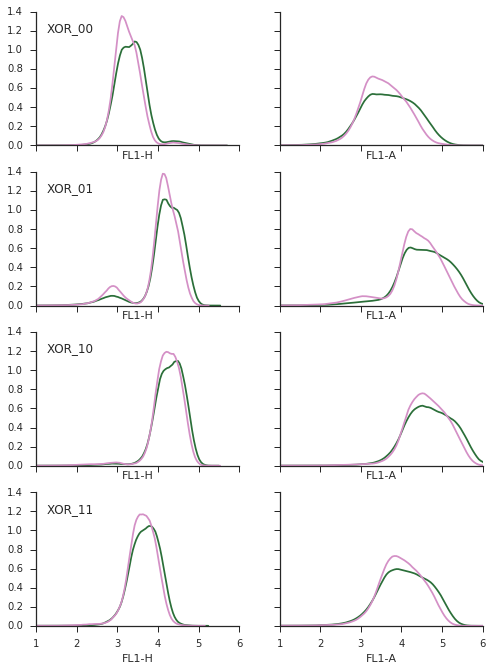

In [11]:
flowViz(dfR2dilute10,originatorLab,flowDate)

# Scratch